In [774]:
# Kaggle 타이타닉 문제는 타이타닉의 승객 중에 생존 유무를 예측하는 것이다.

In [775]:
# Numpy, Pandas 불러오기
import numpy as np
import pandas as pd

# 시각화 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 머신러닝 라이브러리 불러오기
import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from xgboost import XGBClassifier, plot_importance

# 특성 중요도 라이브러리 불러오기
!pip install eli5
import eli5 
from eli5.sklearn import PermutationImportance
from IPython.display import display

In [776]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [777]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic/test.csv')

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [778]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [779]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [780]:
# 아래 커널 참고해서 잘못된 값 수정하기
# https://www.kaggle.com/demidova/titanic-eda-tutorial-with-seaborn
train.loc[train['PassengerId'] == 631, 'Age'] = 48

train.loc[train['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
test.loc[test['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]

In [781]:
train_label = train['Survived']
test_id = test['PassengerId']
total = pd.concat([train.drop(['Survived'], axis=1), test], axis=0).iloc[:,1:]
print(total.shape)
total.head()

(1309, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [782]:
# Training, Test 세트의 결측치 확인하기
# Age, Cabin, Fare, Embarked에서 결측치가 있다.
print(train.isnull().sum())
print('-'*20)
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


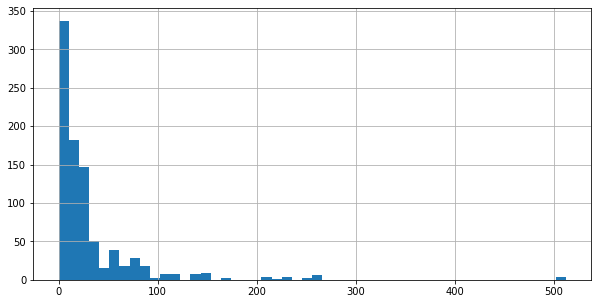

In [783]:
# Fare의 분포가 표준분포와는 많이 다르다.
train['Fare'].hist(bins=50, figsize=(10, 5))

In [784]:
# 티켓 특성을 추출한다.
total['Has_Same_Ticket'] = total.groupby('Ticket')['Ticket'].transform('count')
# total['Ticket'] = total['Ticket'].apply(lambda x:'X' if x.isdigit() else x.split('.')[0].split('/')[0].split(' ')[0].strip())
total['Ticket'] = total['Ticket'].apply(lambda x: 'X' if x.isdigit() else x.replace('.', '').replace('/', '').strip().split(' ')[0])
# total['Ticket'] = total['Ticket'].apply(lambda x:'X' if x.isdigit() else 'Y')

total = pd.get_dummies(total, columns=['Ticket'], prefix='Ticket')
total.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Has_Same_Ticket,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [785]:
# 객실 특성에서 구역별로 특성을 추출한다.
print(total['Cabin'].apply(lambda x:x[:1] if type(x) == str else x).value_counts())
print('-'*20)

# total['Cabin_Isnull'] = total['Cabin'].isnull().apply(lambda x: 1 if x == True else 0)
total['Cabin'] = total['Cabin'].apply(lambda x:x[:1] if type(x) == str else 'M')
# total['Cabin'] = total['Cabin'].replace(['A', 'B', 'C', 'T'], 'ABC')
# total['Cabin'] = total['Cabin'].replace(['D', 'E'], 'DE')
# total['Cabin'] = total['Cabin'].replace(['F', 'G'], 'FG')
total.head()

# # Has_Cabin은 생존율에 연관이 있는 것으로 보인다.
# print(train[['Has_Cabin', 'Survived']].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False))

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: Cabin, dtype: int64
--------------------


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Has_Same_Ticket,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,M,S,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,M,S,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C,S,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,M,S,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [786]:
# Name에서 Title으로 추출해서 구분한다.
total['Title'] = total['Name'].apply(lambda x:x.split(sep='.')[0]).apply(lambda x:x.split(sep=',')[1].strip())
print(total['Title'].value_counts())

# Title 정리하기
total['Title'] = total['Title'].replace(['Dona', 'Lady', 'the Countess', 'Don', 'Sir', 'Jonkheer'], 'Royalty')
total['Title'] = total['Title'].replace(['Dr', 'Major', 'Capt', 'Col', 'Rev'], 'Officer')
total['Title'] = total['Title'].replace('Mlle', 'Miss')
total['Title'] = total['Title'].replace(['Ms', 'Mme'], 'Mrs')
# total['Title'] = total['Title'].map({'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4,
#                                      'Royalty': 5, 'Officer': 6})

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Don               1
Mme               1
Jonkheer          1
Capt              1
Lady              1
Sir               1
the Countess      1
Dona              1
Name: Title, dtype: int64


In [787]:
total['FamilyName'] = total['Name'].apply(lambda x:x.split(sep=',')[0])
train['FamilyName'] = train['Name'].apply(lambda x:x.split(sep=',')[0])
test['FamilyName'] = test['Name'].apply(lambda x:x.split(sep=',')[0])
overlap_familyname = [x for x in train['FamilyName'].unique() if x in test['FamilyName'].unique()]

train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
rate_family = train.groupby('FamilyName')['Survived', 'FamilyName', 'FamilySize'].median()
rate_family.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,Survived,FamilySize
FamilyName,,
Abbing,0.0,1.0
Abbott,0.5,3.0
Abelson,0.5,2.0
Adahl,0.0,1.0
Adams,0.0,1.0


In [788]:
train['Has_Same_Ticket'] = train.groupby('Ticket')['Ticket'].transform('count')
test['Has_Same_Ticket'] = test.groupby('Ticket')['Ticket'].transform('count')
overlap_ticketfreq = [x for x in train['Ticket'].unique() if x in test['Ticket'].unique()]

rate_ticket = train.groupby('Ticket')['Survived', 'Ticket', 'Has_Same_Ticket'].median()
rate_ticket.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,Survived,Has_Same_Ticket
Ticket,,
110152,1.0,3.0
110413,1.0,3.0
110465,0.0,2.0
110564,1.0,1.0
110813,1.0,1.0


In [789]:
overlap_family = dict()
overlap_ticket = dict()

for i in range(len(rate_family)):
    if rate_family.index[i] in overlap_familyname and rate_family.iloc[i, 1] > 1:
        overlap_family[rate_family.index[i]] = rate_family.iloc[i, 0]

for i in range(len(rate_ticket)):
    if rate_ticket.index[i] in overlap_ticketfreq and rate_ticket.iloc[i, 1] > 1:
        overlap_ticket[rate_ticket.index[i]] = rate_ticket.iloc[i, 0]

mean_survival_rate = np.mean(train['Survived'])
family_survival_rate = []
family_survival_rate_NA = []
ticket_survival_rate = []
ticket_survival_rate_NA = []

for i in range(len(train)):
    if train['FamilyName'][i] in overlap_family:
        family_survival_rate.append(overlap_family[train['FamilyName'][i]])
        family_survival_rate_NA.append(1)
    else:
        family_survival_rate.append(mean_survival_rate)
        family_survival_rate_NA.append(0)

for i in range(len(train)):
    if train['Has_Same_Ticket'][i] in overlap_ticket:
        ticket_survival_rate.append(overlap_ticket[train['Has_Same_Ticket'][i]])
        ticket_survival_rate_NA.append(1)
    else:
        ticket_survival_rate.append(mean_survival_rate)
        ticket_survival_rate_NA.append(0)

train['FamilySurvivalRate'] = family_survival_rate
train['FamilySurvivalRateNA'] = family_survival_rate_NA
train['TicketSurvivalRate'] = ticket_survival_rate
train['TicketSurvivalRateNA'] = ticket_survival_rate_NA

In [790]:
family_survival_rate = []
family_survival_rate_NA = []
ticket_survival_rate = []
ticket_survival_rate_NA = []

for i in range(len(test)):
    if test['FamilyName'][i] in overlap_family:
        family_survival_rate.append(overlap_family[test['FamilyName'][i]])
        family_survival_rate_NA.append(1)
    else:
        family_survival_rate.append(mean_survival_rate)
        family_survival_rate_NA.append(0)

for i in range(len(test)):
    if test['Has_Same_Ticket'][i] in overlap_ticket:
        ticket_survival_rate.append(overlap_ticket[test['Has_Same_Ticket'][i]])
        ticket_survival_rate_NA.append(1)
    else:
        ticket_survival_rate.append(mean_survival_rate)
        ticket_survival_rate_NA.append(0)

test['FamilySurvivalRate'] = family_survival_rate
test['FamilySurvivalRateNA'] = family_survival_rate_NA
test['TicketSurvivalRate'] = ticket_survival_rate
test['TicketSurvivalRateNA'] = ticket_survival_rate_NA

train['SurvivalRate'] = (train['FamilySurvivalRate'] + train['TicketSurvivalRate']) / 2
test['SurvivalRate'] = (test['FamilySurvivalRate'] + test['TicketSurvivalRate']) / 2
train['SurvivalRateNA'] = (train['FamilySurvivalRateNA'] + train['TicketSurvivalRateNA']) / 2
test['SurvivalRateNA'] = (test['FamilySurvivalRateNA'] + test['TicketSurvivalRateNA']) / 2
total['SurvivalRate'] = pd.concat([train['SurvivalRate'], test['SurvivalRate']], axis=0)
total['SurvivalRateNA'] = pd.concat([train['SurvivalRateNA'], test['SurvivalRateNA']], axis=0)

In [791]:
# 본인이 속한 가족구성원의 수를 FamilySize에 저장한다.
total['FamilySize'] = total['SibSp'] + total['Parch'] + 1

# Nuclear 특성은 핵가족인 경우는 1, 아니면 0이다.
total['Alone'] = 0
total['Nuclear'] = 0
total['Extended'] = 0
total.loc[total['FamilySize'] == 1, 'Alone'] = 1
total.loc[(2 <= total['FamilySize']) & (total['FamilySize'] <= 4), 'Nuclear'] = 1
total.loc[total['FamilySize'] > 4, 'Extended'] = 1

   Pclass       Fare
0       1  87.508992
1       2  21.179196
2       3  13.302889
--------------------
      Sex       Fare
0  female  46.198097
1    male  26.154601
--------------------
   SibSp       Fare
0      0  25.745192
1      1  48.711300
2      2  48.940576
3      3  71.332090
4      4  32.868750
5      5  46.900000
6      8  69.550000
--------------------
   Parch        Fare
0      0   26.292970
1      1   50.078358
2      2   62.310172
3      3   86.688537
4      4  104.723617
5      5   32.356250
6      6   46.900000
7      9   69.550000
--------------------


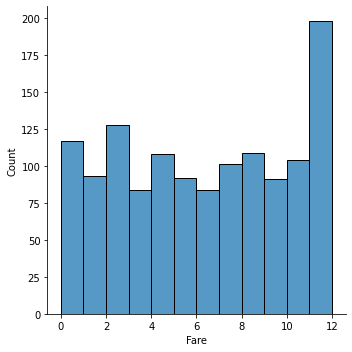

In [792]:
# Fare가 Pcalss, Sex, SibSp, Parch와 관련있음을 확인할 수 있다.
for col in ['Pclass', 'Sex', 'SibSp', 'Parch']:
    print(total[['Fare', col]].groupby([col], as_index=False).mean())
    print('-' * 20)

# Fare 결측치는 Pclass와 Sex를 기준으로 중간값으로 채운다.
total['Fare_Isnull'] = total['Fare'].isnull().apply(lambda x: 1 if x == True else 0)
total['Fare'].fillna(total.groupby(['Pclass', 'SibSp', 'Parch'])['Fare'].transform('median'), inplace=True)
total['ZeroFare'] = total['Fare'].apply(lambda x: 1 if x == 0 else 0)

# Fare를 분위수 기준으로 구간을 나눈다.
total['Fare'] = pd.qcut(total['Fare'], 13, labels=False)

sns.displot(total['Fare'])

   Pclass        Age
0       1  39.047254
1       2  29.506705
2       3  24.816367
--------------------
      Sex        Age
0  female  28.687088
1    male  30.536596
--------------------
     Title        Age
0   Master   5.482642
1     Miss  21.795236
2       Mr  32.197074
3      Mrs  36.866279
4  Officer  46.272727
5  Royalty  41.166667
--------------------


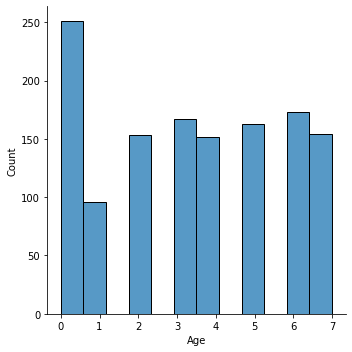

In [793]:
# Age와 관련있어 보이는 변수
for col in ['Pclass', 'Sex', 'Title']:
    print(total[['Age', col]].groupby([col], as_index=False).mean())
    print('-' * 20)

# Age의 결측치는 Pclass와 Title을 기준으로 중간값으로 채운다.
total['Age_Isnull'] = total['Age'].isnull().apply(lambda x: 1 if x==True else 0)
total['Age'].fillna(total.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform('median'), inplace=True)

# Age를 구간을 나눠서 분류한다.
total['Age'] = pd.qcut(total['Age'].astype('int'), 8, labels=False)

sns.displot(total['Age'])

In [794]:
# 출발항 결측치는 가장 많은 출발항 S로 채운다.
print(train['Embarked'].value_counts())
# total['Embarked_Isnull'] = total['Embarked'].isnull().apply(lambda x: 1 if x == True else 0)
total['Embarked'].fillna(total['Embarked'].mode()[0], inplace=True)

# One-Hot Encoding
total = pd.get_dummies(data=total, columns=['Embarked'], prefix='Embarked')
total = pd.get_dummies(data=total, columns=['Cabin'], prefix='Cabin')
total = pd.get_dummies(data=total, columns=['Title'], prefix='Title')

# Label Encoding
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# for col in ['Embarked', 'Pclass', 'Title', 'Cabin']:
#     total[col] = encoder.fit_transform(total[col])

total.head()

S    644
C    168
Q     77
Name: Embarked, dtype: int64


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Has_Same_Ticket,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,FamilyName,SurvivalRate,SurvivalRateNA,FamilySize,Alone,Nuclear,Extended,Fare_Isnull,ZeroFare,Age_Isnull,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,"Braund, Mr. Owen Harris",male,2,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Braund,0.383838,0.0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,6,1,0,11,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cumings,0.691919,0.5,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,3,"Heikkinen, Miss. Laina",female,3,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Heikkinen,0.383838,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5,1,0,10,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Futrelle,0.383838,0.0,2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,3,"Allen, Mr. William Henry",male,5,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Allen,0.383838,0.0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [795]:
# Sex를 0과 1로 나눕니다.
total['Sex'] = total['Sex'].map({'male': 0, 'female': 1}).astype(int)

total['Senior'] = total['Age'].map(lambda x: 1 if x > 70 else 0)
total['Fare_Sex'] = total['Fare'] * total['Sex']
total['Rich_Woman'] = 0
total['Men_3Class'] = 0
total.loc[(total['Pclass'] <= 2) & (total['Sex'] == 0), 'Rich_Woman'] = 1
total.loc[(total['Pclass'] == 3) & (total['Sex'] == 1), 'Men_3Class'] = 1

In [796]:
# 기존의 특성을 제거한다.
total.drop(['Name', 'FamilySize', 'FamilyName'], axis=1, inplace=True)

In [797]:
# 데이터를 훈련, 테스트 세트로 분리한다.
train = total[:len(train)]
test = total[len(train):]

train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Has_Same_Ticket,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,SurvivalRate,SurvivalRateNA,Alone,Nuclear,Extended,Fare_Isnull,ZeroFare,Age_Isnull,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Senior,Fare_Sex,Rich_Woman,Men_3Class
0,3,0,2,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.383838,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,1,1,6,1,0,11,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.691919,0.5,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,11,0,0
2,3,1,3,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.383838,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,3,0,1
3,1,1,5,1,0,10,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.383838,0.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,10,0,0
4,3,0,5,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.383838,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [798]:
columns = train.columns

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [799]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE()
# train, train_label = smote.fit_resample(train, train_label)

In [800]:
X_train, X_val, y_train, y_val =  train_test_split(train, train_label, test_size=0.2, stratify=train_label, random_state=1)
X_test = test
print(X_val.shape)

(179, 74)


In [801]:
cv = StratifiedKFold(5, shuffle=True, random_state=1)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  2.1min


[0]	validation_0-auc:0.79007	validation_1-auc:0.794466
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.823154	validation_1-auc:0.810013
[2]	validation_0-auc:0.848327	validation_1-auc:0.808959
[3]	validation_0-auc:0.861035	validation_1-auc:0.839526
[4]	validation_0-auc:0.859412	validation_1-auc:0.845982
[5]	validation_0-auc:0.857815	validation_1-auc:0.833136
[6]	validation_0-auc:0.870205	validation_1-auc:0.858103
[7]	validation_0-auc:0.871115	validation_1-auc:0.853096
[8]	validation_0-auc:0.870965	validation_1-auc:0.856126
[9]	validation_0-auc:0.878691	validation_1-auc:0.850988
[10]	validation_0-auc:0.880856	validation_1-auc:0.850856
[11]	validation_0-auc:0.887164	validation_1-auc:0.850725
[12]	validation_0-auc:0.891812	validation_1-auc:0.850263
[13]	validation_0-auc:0.891495	validation_1-auc:0.848946
[14]	validation_0-auc:0.895625	validation_1-auc:0.85092

[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.2min finished


[34]	validation_0-auc:0.90341	validation_1-auc:0.866271
[35]	validation_0-auc:0.904449	validation_1-auc:0.867589
[36]	validation_0-auc:0.904149	validation_1-auc:0.867457
[37]	validation_0-auc:0.90535	validation_1-auc:0.867852
[38]	validation_0-auc:0.907449	validation_1-auc:0.867852
[39]	validation_0-auc:0.907002	validation_1-auc:0.868643
[40]	validation_0-auc:0.907749	validation_1-auc:0.869697
[41]	validation_0-auc:0.906906	validation_1-auc:0.869302
[42]	validation_0-auc:0.908316	validation_1-auc:0.866667
[43]	validation_0-auc:0.908383	validation_1-auc:0.866535
[44]	validation_0-auc:0.907866	validation_1-auc:0.866403
[45]	validation_0-auc:0.909347	validation_1-auc:0.866798
[46]	validation_0-auc:0.912009	validation_1-auc:0.866667
[47]	validation_0-auc:0.912109	validation_1-auc:0.865744
[48]	validation_0-auc:0.912242	validation_1-auc:0.864295
[49]	validation_0-auc:0.91336	validation_1-auc:0.863636
[50]	validation_0-auc:0.914629	validation_1-auc:0.865217
[51]	validation_0-auc:0.913961	val

,params,mean_train_score,mean_test_score,rank_test_score
0,"{'learning_rate': 0.01, 'max_depth': 1}",0.791781,0.776687,108
1,"{'learning_rate': 0.01, 'max_depth': 2}",0.802335,0.801930,105
2,"{'learning_rate': 0.01, 'max_depth': 3}",0.832519,0.820270,102
3,"{'learning_rate': 0.01, 'max_depth': 4}",0.839542,0.830080,93
4,"{'learning_rate': 0.01, 'max_depth': 5}",0.852172,0.824495,95
...,...,...,...,...
103,"{'learning_rate': 0.09, 'max_depth': 8}",0.888692,0.849690,30
104,"{'learning_rate': 0.09, 'max_depth': 9}",0.887989,0.855324,6
105,"{'learning_rate': 0.09, 'max_depth': 10}",0.896068,0.852516,17
106,"{'learning_rate': 0.09, 'max_depth': 11}",0.894657,0.852526,14


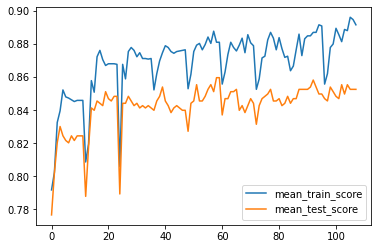

In [802]:
# XGBoost GridSearch
parameters={
            'learning_rate': np.arange(0.01, 0.1, 0.01),
            'max_depth': np.arange(1, 13, 1),
            # 'min_child_weight': np.arange(1, 10, 1),
            #  'n_estimators': np.arange(200, 500, 1),
            #   'colsample_bynode': np.arange(0.2, 1.0, 0.1),
            # 'colsample_bylevel': np.arange(0.2, 1.0, 0.1),
            #   'colsample_bytree': np.arange(0.2, 1.0, 0.1),
            #  'subsample': np.arange(0.2, 1.0, 0.1),
            # 'gamma': [0, 1, 10, 100],
            # 'reg_alpha': [0, 0.4, 1, 5, 10, 100],
            # 'reg_lambda': [0, 0.7, 1, 5, 10, 100],
            #   'scale_pos_weight': [0.01, 0.05, 0.1, 0.5, 0.8, 1, 1.5, 2, 3, 5, 10],
            # 'objective': ['binary:logistic', 'binary:logitraw', 'binary:hinge'],
            }
xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', n_estimators=5000,
                    learning_rate=0.05, subsample=0.7, eval_metric='auc', min_child_weight=1,
                    colsample_bytree=0.4, colsample_bynode=0.3, colsample_bylevel=0.8,
                    scale_pos_weight=1, max_depth=11,
                    gamma=0, reg_alpha=0.4, reg_lambda=0,
                    nthread=-1, random_state=1)
xgb = GridSearchCV(xgb, param_grid=parameters, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3,
                        return_train_score=True)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='auc', early_stopping_rounds=100)
result_grid_xgb = pd.DataFrame(xgb.cv_results_)
print('XGBoost 그리드서치의 최적 파라미터: {}'.format(xgb.best_params_))
print('XGBoost 그리드서치의 최고 모델: {}'.format(xgb.best_estimator_))
print('XGBoost 그리드서치의 최고 점수: {}'.format(round(xgb.best_score_, 3)))
train_score_xgb = round(xgb.score(X_train, y_train) * 100, 3)
val_score_xgb = round(xgb.score(X_val, y_val) * 100, 3)
print('XGBoost 그리드서치의 훈련(검증)세트 점수: {}({})'.format(train_score_xgb, val_score_xgb))
print('XGBoost 그리드서치의 검증세트 정확도: {}'.format(round(accuracy_score(xgb.predict(X_val), y_val) * 100, 3)))
print('XGBoost 그리드서치의 검증세트 정밀도 점수: {}'.format(round(precision_score(xgb.predict(X_val), y_val) * 100, 3)))
print('XGBoost 그리드서치의 검증세트 재현율 점수: {}'.format(round(recall_score(xgb.predict(X_val), y_val) * 100, 3)))
print('XGBoost 그리드서치의 검증세트 f1 점수: {}'.format(round(f1_score(xgb.predict(X_val), y_val) * 100, 3)))
result_grid_xgb[['mean_train_score', 'mean_test_score']].plot()
result_grid_xgb[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]

In [803]:
# xgb = XGBClassifier(booster='gbtree', objective='binary:hinge', n_estimators=5000,
#                     learning_rate=0.01, subsample=0.8, eval_metric='auc', min_child_weight=7,
#                     colsample_bytree=0.5, colsample_bynode=0.5, colsample_bylevel=0.5,
#                     scale_pos_weight=1, max_depth=5,
#                     gamma=0, reg_alpha=0, reg_lambda=0,
#                     nthread=-1, random_state=1)
# xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='auc', early_stopping_rounds=100, verbose=True)

In [804]:
# train_score_xgb = round(xgb.score(X_train, y_train) * 100, 3)
# val_score_xgb = round(xgb.score(X_val, y_val) * 100, 3)
# print('XGBoost의 훈련(검증)세트 점수: {}({})'.format(train_score_xgb, val_score_xgb))
# print('XGBoost의 검증세트 정확도: {}'.format(round(accuracy_score(xgb.predict(X_val), y_val) * 100, 3)))
# print('XGBoost의 검증세트 정밀도 점수: {}'.format(round(precision_score(xgb.predict(X_val), y_val) * 100, 3)))
# print('XGBoost의 검증세트 재현율 점수: {}'.format(round(recall_score(xgb.predict(X_val), y_val) * 100, 3)))
# print('XGBoost의 검증세트 f1 점수: {}'.format(round(f1_score(xgb.predict(X_val), y_val) * 100, 3)))

# results = xgb.evals_result()
# epochs = len(results['validation_0']['auc'])
# x_axis = range(0, epochs)

# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['auc'], label='train')
# ax.plot(x_axis, results['validation_1']['auc'], label='val')
# plt.legend()
# plt.ylabel('AUC')
# plt.title('XGBoost AUC')

In [805]:
# print('XGBoost의 presion_recall_curve')
# precision, recall, thresholds = precision_recall_curve(y_val, xgb.decision_function(X_val))
# plt.plot(precision, recall)

In [806]:
# Confusion Matrix
print('XGBoost의 confusion matrix')
print(confusion_matrix(y_pred=xgb.predict(X_val), y_true=y_val))
print('-' * 60)
print('XGBoost의 classification report')
print(classification_report(y_pred=xgb.predict(X_val), y_true=y_val))
print('-' * 60)

XGBoost의 confusion matrix
[[98 12]
 [17 52]]
------------------------------------------------------------
XGBoost의 classification report
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

------------------------------------------------------------


In [807]:
# 결과를 CSV로 저장한다.
y_test = xgb.predict(X_test)
submission = pd.DataFrame({'PassengerId': test_id, 'Survived': y_test})
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/titanic/titanic_submission_XGB.csv', index=False)

In [808]:
# 각각의 모델의 특성 중요도 확인하기
print('XGBoost의 특성 중요도')
perm = PermutationImportance(xgb, scoring='accuracy', random_state=10).fit(X_val, y_val) 
display(eli5.show_weights(perm, top=None, feature_names=columns.tolist()))
print('-' * 40)
# sorted(sklearn.metrics.SCORERS.keys())

XGBoost의 특성 중요도


Weight,Feature
0.0223 ± 0.0187,Sex
0.0190 ± 0.0230,Title_Mr
0.0123 ± 0.0045,Title_Master
0.0112 ± 0.0122,Fare_Sex
0.0089 ± 0.0152,SurvivalRate
0.0056 ± 0.0000,Rich_Woman
0.0056 ± 0.0122,Age
0.0045 ± 0.0045,Title_Miss
0.0022 ± 0.0089,Title_Mrs
0.0011 ± 0.0045,Ticket_STONO


----------------------------------------
